In [1]:
from pathlib import Path
from kedro.framework.context import load_context

current_dir = Path.cwd()
proj_path = current_dir.parent
context = load_context(proj_path)

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [3]:
import codecs

df_train = catalog.load("train")
df_test = catalog.load("test")
df_stage = catalog.load("stagedata")
df_weapon = catalog.load("weapon")


2020-09-24 07:42:06,100 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...
2020-09-24 07:42:06,287 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...


c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020-09-24 07:42:06,376 - kedro.io.data_catalog - INFO - Loading data from `stagedata` (CSVDataSet)...
2020-09-24 07:42:06,378 - kedro.io.data_catalog - INFO - Loading data from `weapon` (CSVDataSet)...


In [ ]:
train_x = df_train.drop("y", axis=1)
train_y = df_train["y"]
train_x = torch.tensor(train_x.values)
train_y = torch.tensor(train_y.values, dtype=torch.int64)


In [4]:
cat_features = [
    "period", "game-ver", "lobby-mode", "lobby", "mode", "stage", "A1-weapon",
    "A2-weapon", "A3-weapon", "A4-weapon", "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon",
    "A1-rank", "A2-rank", "A3-rank", "A4-rank", "B1-rank", "B2-rank", "B3-rank", "B4-rank", 
]
num_features = [
    "A1-level", "A2-level", "A3-level", "A4-level",
    "B1-level", "B2-level", "B3-level", "B4-level"
]
target_col = "y"
target_id = "id"
players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]

In [5]:
cat_features.remove("period")
cat_features.remove("lobby")
cat_features.remove("game-ver")
data = pd.concat([df_train.drop([target_id, target_col], axis=1), df_test.drop([target_id], axis=1)])
data = data.drop(["period", "lobby", "game-ver"], axis=1)
y = torch.tensor(df_train[target_col].values).flatten()
test_id = df_test[target_id]

In [6]:
df_weapon["category"] = df_weapon["category1"] + df_weapon["category2"]
df_weapon = df_weapon.drop(["category1", "category2"], axis=1)
df_weapon = df_weapon.drop(["i"], axis=1)

In [7]:
data.columns

Index(['lobby-mode', 'mode', 'stage', 'A1-weapon', 'A1-rank', 'A1-level',
       'A2-weapon', 'A2-rank', 'A2-level', 'A3-weapon', 'A3-rank', 'A3-level',
       'A4-weapon', 'A4-rank', 'A4-level', 'B1-weapon', 'B1-rank', 'B1-level',
       'B2-weapon', 'B2-rank', 'B2-level', 'B3-weapon', 'B3-rank', 'B3-level',
       'B4-weapon', 'B4-rank', 'B4-level'],
      dtype='object')

In [8]:
weapons = [p + "-weapon" for p in players]
rank = {"c-":1, "c":2, "c+":3, "b-":4, "b":5, "b+":6, "a-":7, "a":8, "a+":9, "s":10, "s+":11, "x":12}
for player in players:
    data[f"{player}-rank"] = data[f"{player}-rank"].map(rank)
    data[f"{player}-rank"] = data[f"{player}-rank"].fillna(0)
    data[f"{player}-weapon"] = data[f"{player}-weapon"].fillna(data[f"{player}-weapon"].value_counts().index[0])
    data[f"{player}-level"] = data[f"{player}-level"].fillna("-1")
print(data["A2-rank"].unique())

[ 0.  8. 12. 10.  4. 11.  9.  2.  7.  3.  6.  5.  1.]


In [9]:
for weapon in weapons:
    temp_weapon_detail = data[[weapon]].join(df_weapon.set_index("key"), on=weapon)
    weapon_detail = [weapon[:3] + col for col in temp_weapon_detail.columns]
    cat_features.extend(weapon_detail)
    temp_weapon_detail.columns = weapon_detail
    data = pd.concat([data, temp_weapon_detail], axis=1)
    data = data.drop(weapon, axis=1)
    cat_features.remove(weapon)    
print(data)

      lobby-mode      mode    stage  A1-rank  A1-level  A2-rank  A2-level  \
0        regular  nawabari  sumeshi      0.0       139      0.0     118.0   
1        regular  nawabari  arowana      0.0       198      0.0      77.0   
2          gachi      hoko      ama      7.0       114      8.0      68.0   
3        regular  nawabari   engawa      0.0       336      0.0     131.0   
4          gachi      hoko  chozame     12.0       299     12.0      97.0   
...          ...       ...      ...      ...       ...      ...       ...   
28335      gachi    yagura  battera     12.0        67     12.0      62.0   
28336      gachi    yagura  anchovy      1.0        25      1.0      18.0   
28337      gachi    yagura    zatou     12.0       386     12.0     136.0   
28338      gachi     asari    hokke     11.0       185     11.0     103.0   
28339      gachi    yagura  sumeshi     12.0       182     12.0     111.0   

       A3-rank  A3-level  A4-rank  ... B3-rate     B3-category  \
0        

In [12]:
def range_average(usedata, team):
    usedata[f"{team}-range_ave"] = (usedata[f"{team}1-range"] + usedata[f"{team}2-range"] + usedata[f"{team}3-range"] + usedata[f"{team}4-range"]) / 4
    return usedata[f"{team}-range_ave"]

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
data["A-range_ave"] = range_average(data, "A")
data["B-range_ave"] = range_average(data, "B")
print(data)

      lobby-mode      mode    stage  A1-rank  A1-level  A2-rank  A2-level  \
0        regular  nawabari  sumeshi      0.0       139      0.0     118.0   
1        regular  nawabari  arowana      0.0       198      0.0      77.0   
2          gachi      hoko      ama      7.0       114      8.0      68.0   
3        regular  nawabari   engawa      0.0       336      0.0     131.0   
4          gachi      hoko  chozame     12.0       299     12.0      97.0   
...          ...       ...      ...      ...       ...      ...       ...   
28335      gachi    yagura  battera     12.0        67     12.0      62.0   
28336      gachi    yagura  anchovy      1.0        25      1.0      18.0   
28337      gachi    yagura    zatou     12.0       386     12.0     136.0   
28338      gachi     asari    hokke     11.0       185     11.0     103.0   
28339      gachi    yagura  sumeshi     12.0       182     12.0     111.0   

       A3-rank  A3-level  A4-rank  ...         B4-B4-weapon  B4-subweapon  

In [116]:
cat_szs = []
for cat in cat_features:
    data[cat] = data[cat].astype('category')
    cat_szs.append(len(data[cat].cat.categories))
    data[cat] = data[cat].cat.codes.values
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [117]:
X = data[:len(df_train.index)]
X_test = data[len(df_train.index):]

nums = np.stack([X[col].astype(np.float16).values for col in num_features], 1)
nums = torch.tensor(nums, dtype=torch.float)
cats = np.stack([X[col].values for col in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int64)
print(f"nums shape: {nums.shape}")
print(f"cats shape: {cats.shape}")
nums_test = np.stack([X_test[col].astype(np.float16).values for col in num_features], 1)
nums_test = torch.tensor(nums_test, dtype=torch.float)
cats_test = np.stack([X_test[col].values for col in cat_features], 1)
cats_test = torch.tensor(cats_test, dtype=torch.int64)

nums shape: torch.Size([66125, 8])
cats shape: torch.Size([66125, 75])


In [118]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x


In [119]:
torch.manual_seed(33)
model = TabularModel(emb_szs, nums.shape[1], 2, [200,100], p=0.3)
# print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


kf = KFold(n_splits=4, shuffle=True, random_state=42)

cat_train: 49593, cat_valid 16532, num_train 49593, num_valid 16532
y_train: 49593, y_valid: 16532
epoch:   1  loss: 0.80423737
epoch:   1  valid loss: 0.76948315
epoch:  10  loss: 0.70818061

Duration: 46 seconds
CE Loss: 0.72750157
accuracy: 0.51415437
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.71174383
epoch:   1  valid loss: 0.70365465
epoch:  10  loss: 0.68829429

Duration: 46 seconds
CE Loss: 0.69362950
accuracy: 0.55284012
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.69144446
epoch:   1  valid loss: 0.67565268
epoch:  10  loss: 0.67595577

Duration: 46 seconds
CE Loss: 0.67509896
accuracy: 0.57909382
cat_train: 49594, cat_valid 16531, num_train 49594, num_valid 16531
y_train: 49594, y_valid: 16531
epoch:   1  loss: 0.67974317
epoch:   1  valid loss: 0.66106033
epoch:  10  loss: 0.67020065

Duration: 46 seconds
CE Loss: 0.66186863
a

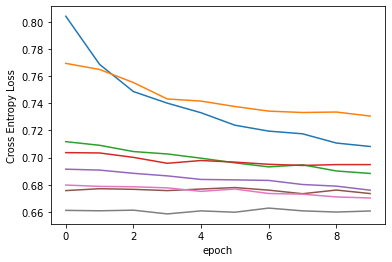

In [120]:
is_short_run = False
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    cat_train = cats[train_index]
    cat_valid = cats[valid_index]
    num_train = nums[train_index]
    num_valid = nums[valid_index]
    y_train = y[train_index]
    y_valid = y[valid_index]
    print(f"cat_train: {len(cat_train)}, cat_valid {len(cat_valid)}, num_train {len(num_train)}, num_valid {len(num_valid)}")
    print(f"y_train: {len(y_train)}, y_valid: {len(y_valid)}")


    start_time = time.time()

    epochs = 10
    losses = []
    valid_losses = []

    for i in range(epochs):
        i+=1
        y_pred = model(cat_train, num_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss)

        if i%10 == 1:
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_val = model(cat_valid, num_valid)
            valid_loss = criterion(y_val, y_valid)
            valid_losses.append(valid_loss)
            if i%10 == 1:
                print(f'epoch: {i:3}  valid loss: {valid_loss.item():10.8f}')

    print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

    plt.plot(range(epochs), losses)
    plt.plot(range(epochs), valid_losses)
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch');

    with torch.no_grad():
        y_val = model(cat_valid, num_valid)
        accuracy = accuracy_score(np.argmax(y_val, axis=1), y_valid)
        loss = criterion(y_val, y_valid)
    print(f'CE Loss: {loss:.8f}')
    print(f'accuracy: {accuracy:.8f}')
    
    with torch.no_grad():
        y_test = np.argmax(model(cats_test, nums_test), axis=1)
    if is_short_run:
        break
    
submission_df = pd.DataFrame({target_id: test_id.values, target_col: y_test})
submission_df.to_csv("submission.csv", index=False)